<a href="https://colab.research.google.com/github/ayami-n/Flax_text_prediction/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Flax_text_prediction

/content/drive/MyDrive/Flax_text_prediction


# Import libs

In [ ]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git
!pip install flax
!pip install git+https://github.com/deepmind/optax.git

In [26]:
import jax
from jax import random  # to create random values for initalizing a model (Flax requires)
import jax.numpy as jnp

# Flax for building model
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

from flax import linen as nn
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze

# Optax for optimizor 
import optax

# Transformers
!pip install transformers
from transformers import FlaxAutoModelForSequenceClassification, RobertaTokenizer, RobertaConfig # as we use Roberta model
from transformers.modeling_flax_utils import FlaxPreTrainedModel  # FlaxMLPModule is still stateless

# others
import pandas as pd
from tqdm import tqdm
from typing import Callable, Any
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Config

In [4]:
model_checkpoint = 'siebert/sentiment-roberta-large-english' # https://huggingface.co/docs/transformers/model_doc/roberta#roberta
seed = 0  # for building our model

tokenizer = RobertaTokenizer.from_pretrained(model_checkpoint)  # this tokenizer converts numeric from string: the values are different if you select different model_checkpoint

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

# Tokenaization

In [ ]:
'''
https://stackoverflow.com/questions/65246703/how-does-max-length-padding-and-truncation-arguments-work-in-huggingface-bertt
adding [CLS] token at the beginning of the sentence, and [SEP] token at the end of sentence.
[CLS] I love you [SEP] is expected by BERT. 
tokenizer gives [CLS] and [SEP] usually
'''

In [5]:
df = pd.read_csv("./kaggle/train.csv")  # import train datasets
new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}  # to replace 
df = df.replace(new_label) 

In [ ]:
max = 0
max_str = "Who is Max?"
words_list = []
for itr, val in enumerate(df['discourse_text'].to_numpy()):
  words = val.split()
  words_list.append(len(words))

  if len(words) > max:
    max = len(words)
    max_str = val

print(pd.Series(list(filter(lambda x: (x <= 256), words_list))).count(), len(words_list))    

36566 36765


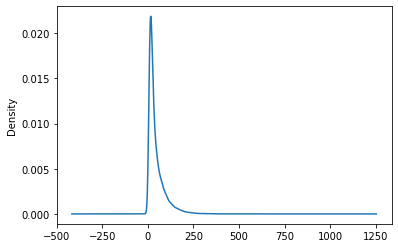

In [ ]:
'''
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.plot.kde.html
'''
pd.Series(words_list).plot.kde()  # most words are less than 250

In [6]:
max_len = 256  # input text should be the same length (most words <= 256)

def tokenaize(texts, tokenizer, max_len):  # df text comes and return as numerical 
    input_ids = []
    attention_mask = []
    
    for text in tqdm(texts):  # it takes over 1 min (numpy and list)
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length', return_tensors='jax') # add_special_tokens=True is default: truncation=True is cutting off longer sentences (longer than max_length)
        input_ids.append(token['input_ids']) # separate: the values (text) are converted by the tokenizer
        attention_mask.append(token['attention_mask']) # separate: the values (attention-mask) are converted by the tokenizer
        
    return jnp.array(input_ids), jnp.array(attention_mask)

In [7]:
train_df, val_df = train_test_split(df, test_size=0.05, random_state=seed)  # spliting datasets 95% train and 5% val

train_input_ids, train_attention_mask = tokenaize(train_df['discourse_text'].to_numpy()[:2000], tokenizer, max_len)  # pandas is slow -> numpy is the fastest (list is considerable)
val_input_ids, val_attention_mask = tokenaize(val_df['discourse_text'].to_numpy()[:50], tokenizer, max_len)

100%|██████████| 50/50 [00:00<00:00, 392.06it/s]


In [ ]:
tokenizer.convert_ids_to_tokens(train_input_ids[0].squeeze())[:30]  # checking the converted id's

['<s>',
 'In',
 'Ġconclusion',
 ',',
 'Ġthe',
 'ĠElectoral',
 'ĠCollege',
 'Ġshould',
 'Ġbe',
 'Ġkept',
 '.',
 'ĠIt',
 'Ġinduces',
 'Ġthe',
 'Ġcandidates',
 '.',
 'ĠIt',
 'Ġrestores',
 'Ġsome',
 'Ġof',
 'Ġthe',
 'Ġweight',
 'Ġthat',
 'Ġthe',
 'Ġlarge',
 'Ġstates',
 'Ġloses',
 '.',
 'ĠIt',
 'Ġavoids']

# Create a model

In [ ]:
train_label = jnp.array(train_df['discourse_effectiveness'].to_numpy())  # jnp (DeviceArray) as model requires
val_label = jnp.array(val_df['discourse_effectiveness'].to_numpy())

In [8]:
# the model size is 1.32G
pretrained_roberta = FlaxAutoModelForSequenceClassification.from_pretrained(model_checkpoint, seed=seed)  

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [10]:
out = pretrained_roberta(train_input_ids[0], train_attention_mask[0], output_hidden_states=True)
out.hidden_states[0][:,0,:]

DeviceArray([[-0.5965639 ,  0.10398328,  0.13116145, ..., -0.33736432,
              -0.38228214,  0.20476595]], dtype=float32)

In [57]:
labels_onehot = jax.nn.one_hot([0], num_classes=3)
test_dense = nn.Dense(3)
variables = test_dense.init(random.PRNGKey(0), out.hidden_states[0][:,0,:])

logits = test_dense.apply(variables, out.hidden_states[0][:,0,:])
val = optax.softmax_cross_entropy(logits, labels_onehot)
val

DeviceArray([0.67807037], dtype=float32)

In [51]:
class MyNLP(nn.Module):
    roberta: nn.Module

    @nn.compact
    def __call__(self, input_ids, attention_mask, train=True):  # https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ 
        out = self.roberta(input_ids, attention_mask, output_hidden_states=True)  # extract all hidden layers: but we need the last (attention) layer, in particular, [CLS]  
        cls_embedding = out.hidden_states[0][:,0,:] # (1, 1024): [:,0,:] -> first : is all sentences, 0 is [CLS], last : is all hidden unit outputs

        #### Transfer Learning ####
        out = nn.Dense(features=512, name="First")(cls_embedding)
        out = nn.Dense(features=256, name="Second")(out)

        out = nn.Dropout(0.1, deterministic=True)(out)  # must pass deteministic 

        out = nn.Dense(features=64, name="Third")(out)
        out = nn.Dense(features=3, name="Last")(out)

        return out

In [52]:
### initialize the model ###
init_rng = jax.random.PRNGKey(0)

model = MyNLP(pretrained_roberta)  # create a model

print(model.tabulate(init_rng,train_input_ids[0], train_attention_mask[0]))  # display the summary
variables = model.init(init_rng,train_input_ids[0], train_attention_mask[0])   

                      MyNLP Summary                       
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path      ┃ outputs        ┃ params                    ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs    │ - int32[1,256] │                           │
│           │ - int32[1,256] │                           │
├───────────┼────────────────┼───────────────────────────┤
│ Dropout_0 │ float32[1,256] │                           │
├───────────┼────────────────┼───────────────────────────┤
│ First     │ float32[1,512] │ bias: float32[512]        │
│           │                │ kernel: float32[1024,512] │
│           │                │                           │
│           │                │ 524,800 (2.1 MB)          │
├───────────┼────────────────┼───────────────────────────┤
│ Last      │ float32[1,3]   │ bias: float32[3]          │
│           │                │ kernel: float32[64,3]     │
│           │                │                           │
│           │                │ 195 (780 B)               │
├───────────┼────────────────┼───────────────────────────┤
│ Second    │ float32[1,256] │ bias: float32[256]        │
│           │                │ kernel: float32[512,256]  │
│           │                │                           │
│           │                │ 131,328 (525.3 KB)        │
├───────────┼────────────────┼───────────────────────────┤
│ Third     │ float32[1,64]  │ bias: float32[64]         │
│           │                │ kernel: float32[256,64]   │
│           │                │                           │
│           │                │ 16,448 (65.8 KB)          │
├───────────┼────────────────┼───────────────────────────┤
│ MyNLP     │ float32[1,3]   │                           │
├───────────┼────────────────┼───────────────────────────┤
│           │          Total │ 672,771 (2.7 MB)          │
└───────────┴────────────────┴───────────────────────────┘
                                                          
            Total Parameters: 672,771 (2.7 MB)            

In [53]:
# inserting the pretrained parameters into the correct place on the new parameter structure as names will matter 

#### add randomly initialized params with pretrained params ####
variables = unfreeze(variables)  # unfreeze: Makes a mutable copy of a FrozenDict mutable by transforming it into (nested) dict
variables['params']['RoberTa'] = pretrained_roberta.params  # adding roberta params to the randomly initialized params
variables = freeze(variables)  # freeze: An immutable variant of the Python dict.

In [54]:
preds = model.apply(variables, train_input_ids[0], train_attention_mask[0])
preds

DeviceArray([[ 0.27195293, -0.00697634,  0.1406946 ]], dtype=float32)

In [60]:
print(optax.softmax_cross_entropy(preds, labels_onehot))

[0.96834594]


In [70]:
variables['params']['kernel'].shape

(1024, 3)

## Define the training state

In [73]:
params = variables['params']
lr = 2e-5  # 0.00002
opt = optax.adam(learning_rate=lr, b1=0.9, b2=0.999)

In [81]:
opt

GradientTransformation(init=<function chain.<locals>.init_fn at 0x7f3b1a626c20>, update=<function chain.<locals>.update_fn at 0x7f3b1a6268c0>)

In [87]:
class TrainState(train_state.TrainState):  # add model's forward pass as a loss_function  
    loss_function: Callable = flax.struct.field(pytree_node=False)   

In [78]:
def loss_function(logits, labels, num_labels):  # this function go to extended TrainsState class
  xentropy = optax.softmax_cross_entropy(logits, jax.nn.one_hot(labels, num_classes=num_labels))
  return jnp.mean(xentropy)

def compute_loss(params, input_ids, attention_mask, labels):
   logits = model.apply(variables, input_ids, attention_mask, train=True)
   num_classes = logits.shape[-1]
   loss = loss_function(logits, labels, num_classes).mean()
   return loss  

In [88]:
state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=opt, 
    loss_function=loss_function
    )

In [91]:
print(state.loss_function(preds, [0], 3))

0.96834594


In [ ]:
# transform the loss function to get the gradients
grad_fn = jax.value_and_grad(compute_loss)

In [ ]:
def _train_step(params, opt_state, input_ids, labels):
   # do the forward pass and get the loss and gradients
   loss, grads = grad_fn(params, input_ids, labels)

   # use the gradients to update parameters
   updates, opt_state = opt.update(grads, opt_state)
   updated_params = optax.apply_updates(params, updates)

   return updated_params, opt_state, loss

train_step = jax.jit(_train_step)

In [ ]:
# train loop
for i in range(2):
   params, opt_state, loss = train_step(params, opt_state, train_input_ids, train_label)

In [ ]:
state = TrainState.create(
    apply_fn=model.__call__,
    params=model.params,
    tx=opt,
    logits_function=eval_function,
    loss_function=loss_function,
)

In [ ]:
out = model.(train_input_ids[0])
print(out)

# Validation

In [ ]:
test = pd.read_csv("./kaggle/test.csv") 